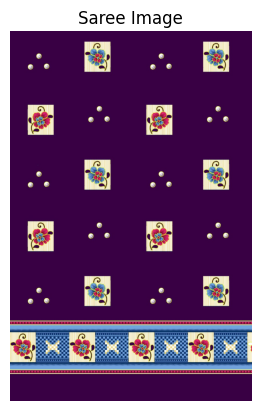

Hello
[array([56,  0, 67]), array([152, 140, 103]), array([226, 216, 150]), array([253, 250, 223]), array([118,  20,  42]), array([112, 158, 212]), array([ 13,  52, 105]), array([200,  43,  94])] [1285928, 16955, 85370, 80270, 29239, 88177, 60977, 25084]

Dominant Colors and HEX Codes:
RGB: [56  0 67], HEX: #380043, Proportion: 76.91%
RGB: [152 140 103], HEX: #988c67, Proportion: 1.01%
RGB: [226 216 150], HEX: #e2d896, Proportion: 5.11%
RGB: [253 250 223], HEX: #fdfadf, Proportion: 4.80%
RGB: [118  20  42], HEX: #76142a, Proportion: 1.75%
RGB: [112 158 212], HEX: #709ed4, Proportion: 5.27%
RGB: [ 13  52 105], HEX: #0d3469, Proportion: 3.65%
RGB: [200  43  94], HEX: #c82b5e, Proportion: 1.50%


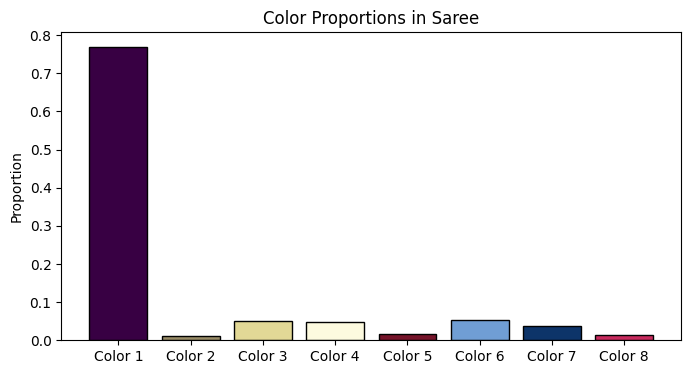

[{'necessary_dyes': [('BRILL BLUE BG 200%', 0.23013371400744576), ('LUMINOUS RED G', 0.18307016043966515), ('NAVY BLUE S2G', 0.06496808484422557), ('DARK RED 2B', 0.0670295187800352), ('BLACK R LIQUID', 0.45479852192862835)], 'resulting_rgb': array([55.99999402,  0.        , 67.00001193]), 'target_rgb': array([56,  0, 67])}, {'necessary_dyes': [('YELLOW 4G 200%', 0.16914392605135953), ('CYANINE VIOLET XF', 0.08784640281247072), ('RED VIOLET XF', 0.04709336002503031), ('LUMINOUS YELLOW 10GN', 0.05830825694397371), ('BRILL BLUE BG 200%', 0.050364040246351), ('YELLOW 4GLS', 0.07139294149131978), ('GOLDEN YELLOW 2GD', 0.05362378479701322), ('BLUE 2RX', 0.05339299732267632), ('SCARLET 3R 150%', 0.04822909277583504), ('LUMINOUS RED G', 0.07831578267839878), ('TURQ. BLUE SBR', 0.11757189084591817), ('GREEN 2B 200%', 0.060855164056244804), ('DARK RED 2B', 0.05051974408209785), ('BLACK R LIQUID', 0.053342615871310804)], 'resulting_rgb': array([151.9999667 , 140.00005351, 103.00000717]), 'target

In [2]:
import numpy as np
import random
import json
from collections import Counter
from sklearn.cluster import KMeans
from matplotlib.colors import to_hex, to_rgb
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import cv2

# Load dye details
with open("dye_detail.json", "r") as file:
    dyes = json.load(file)

# Extract RGB values from dyes
rgb_values = np.array([dye["rgb"] for dye in dyes])

# Genetic Algorithm Parameters
POPULATION_SIZE = 100
NUM_GENERATIONS = 500
MUTATION_RATE = 0.1
CROSSOVER_RATE = 0.7
TOURNAMENT_SIZE = 25

# Fitness function: lower is better
def fitness_function(proportions, target_rgb):
    mixed_rgb = np.dot(proportions, rgb_values)
    error = np.sqrt(np.sum((mixed_rgb - target_rgb) ** 2))  # Euclidean distance
    return error

# Create an initial population
def create_population(size, num_dyes):
    return np.random.dirichlet(np.ones(num_dyes), size)

# Select parents using tournament selection
def tournament_selection(population, fitness, tournament_size):
    selected_indices = random.sample(range(len(population)), tournament_size)
    best_index = min(selected_indices, key=lambda idx: fitness[idx])
    return population[best_index]

# Perform crossover between two parents
def crossover(parent1, parent2):
    if random.random() < CROSSOVER_RATE:
        crossover_point = random.randint(1, len(parent1) - 1)
        child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        return child1, child2
    return parent1, parent2

# Perform mutation on a single individual
def mutate(individual):
    if random.random() < MUTATION_RATE:
        index = random.randint(0, len(individual) - 1)
        adjustment = np.random.uniform(-0.1, 0.1)
        individual[index] = max(0, min(1, individual[index] + adjustment))
    return individual / individual.sum()  # Ensure proportions sum to 1

# Main Genetic Algorithm for a single target color
def genetic_algorithm(target_rgb):
    num_dyes = len(dyes)
    population = create_population(POPULATION_SIZE, num_dyes)
    best_solution = None
    best_fitness = float("inf")

    for generation in range(NUM_GENERATIONS):
        fitness = np.array([fitness_function(individual, target_rgb) for individual in population])
        next_population = []

        for _ in range(POPULATION_SIZE // 2):
            # Select parents
            parent1 = tournament_selection(population, fitness, TOURNAMENT_SIZE)
            parent2 = tournament_selection(population, fitness, TOURNAMENT_SIZE)

            # Crossover and mutation
            child1, child2 = crossover(parent1, parent2)
            child1 = mutate(child1)
            child2 = mutate(child2)

            next_population.extend([child1, child2])

        population = np.array(next_population)

        # Track the best solution
        current_best_idx = np.argmin(fitness)
        if fitness[current_best_idx] < best_fitness:
            best_fitness = fitness[current_best_idx]
            best_solution = population[current_best_idx]

    return best_solution, best_fitness

# Read and preprocess image
def read_and_preprocess_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Extract colors from image
def extract_colors_with_codes(image_path, num_colors):
    image = read_and_preprocess_image(image_path)
    plt.imshow(image)
    plt.title("Saree Image")
    plt.axis("off")
    plt.show()
    pixels = image.reshape((-1, 3))

    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(pixels)

    colors = kmeans.cluster_centers_.astype(int)
    labels = kmeans.labels_

    counts = Counter(labels)
    sorted_colors = [colors[i] for i in counts.keys()]
    sorted_counts = [counts[i] for i in counts.keys()]

    hex_codes = [to_hex(np.array(color) / 255) for color in sorted_colors]

    return sorted_colors, hex_codes, sorted_counts

# Display RGB and HEX codes
def display_color_codes(colors, hex_codes, counts):
    total_pixels = sum(counts)
    print("\nDominant Colors and HEX Codes:")
    for color, hex_code, count in zip(colors, hex_codes, counts):
        proportion = count / total_pixels * 100
        print(f"RGB: {color}, HEX: {hex_code}, Proportion: {proportion:.2f}%")

# Plot color proportions
def plot_colors(colors, counts):
    total_pixels = sum(counts)
    proportions = [count / total_pixels for count in counts]

    plt.figure(figsize=(8, 4))
    for i, (color, proportion) in enumerate(zip(colors, proportions)):
        plt.bar(i, proportion, color=np.array(color) / 255, edgecolor="black")

    plt.xticks(range(len(colors)), [f"Color {i+1}" for i in range(len(colors))])
    plt.ylabel("Proportion")
    plt.title("Color Proportions in Saree")
    plt.show()

def optimize_dye_proportions(dyes_with_proportions, target_rgb, threshold=1e-3):
    """
    Optimizes the proportions of dyes to match a target RGB color.
    
    Args:
        dyes_with_proportions (list): A list of dictionaries, each with keys 'name' and 'rgb'.
        target_rgb (list or np.array): The target RGB color as a list or array.
        threshold (float): Minimum proportion threshold to include a dye in the result.
    
    Returns:
        dict: A dictionary with the following keys:
              - 'necessary_dyes': List of tuples (dye name, proportion) for dyes with non-negligible proportions.
              - 'resulting_rgb': The RGB color obtained from the optimized proportions.
              - 'target_rgb': The target RGB color.
    """
    target_rgb = np.array(target_rgb)
    dye_rgbs = np.array([dye["rgb"] for dye in dyes_with_proportions])
    
    # Define the objective function (mean squared error)
    def objective(proportions):
        resulting_rgb = np.dot(proportions, dye_rgbs)
        error = np.sum((target_rgb - resulting_rgb) ** 2)
        return error

    # Constraints: proportions must sum to 1 and be non-negative
    constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
    bounds = [(0, 1) for _ in range(len(dyes_with_proportions))]
    
    # Initial guess (equal proportions)
    initial_guess = np.ones(len(dyes_with_proportions)) / len(dyes_with_proportions)
    
    # Solve the optimization problem
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)
    proportions = result.x
    
    # Filter out dyes with negligible proportions
    necessary_dyes = [
        (dyes_with_proportions[i]['name'], proportions[i])
        for i in range(len(dyes_with_proportions))
        if proportions[i] > threshold
    ]
    
    # Calculate resulting RGB
    resulting_rgb = np.dot(proportions, dye_rgbs)
    
    return {
        "necessary_dyes": necessary_dyes,
        "resulting_rgb": resulting_rgb,
        "target_rgb": target_rgb
    }

# Main function
def main():
    image_path = "../training_data/002.jpeg"
    num_colors = 8

    # Extract colors and display information
    colors, hex_codes, counts = extract_colors_with_codes(image_path, num_colors)
    print("Hello")
    print(colors,counts)
    display_color_codes(colors, hex_codes, counts)

    # Plot color proportions
    plot_colors(colors, counts)

    # Run genetic algorithm for each extracted color
    results = []
    for target_rgb in colors:
        target_rgb = np.array(target_rgb)
    
    # Call the genetic algorithm (assuming you have a working genetic_algorithm function)
        best_proportions, best_error = genetic_algorithm(target_rgb)

    # Calculate resulting RGB from optimal proportions
        resulting_rgb = np.dot(best_proportions, [dye["rgb"] for dye in dyes]).round().astype(int)

    #     optimal_proportions = []

    # # Display the results and filter negligible proportions
    #     print("\nOptimal Proportions:")
    #     for dye, proportion in zip(dyes, best_proportions):
    #         if proportion > 0.01:  # Filter negligible proportions
    #             print(f"{dye['color']}: {proportion:.2%}")
    #             optimal_proportions.append({"name": dye["color"], "proportion": proportion})

    # Create a list of dye proportions with their details
        dyes_with_proportions = [
            {"name": dye["color"], "rgb": dye["rgb"]}
            for dye, proportion in zip(dyes, best_proportions)
            if proportion > 0.01  # Filter negligible proportions
    ]
    
    # Now call optimize_dye_proportions with the filtered dyes_with_proportions
        result = optimize_dye_proportions(dyes_with_proportions, target_rgb)
    
    # Collect the results for this color
        results.append(result)
    print(results)
# Print the final results
    i = 0
    for result in results:
        print("\n",i)
        for dye_name, proportion in result["necessary_dyes"]:
            print(f"{dye_name}: {proportion:.4f}")
        print("\nResulting RGB:", result["resulting_rgb"])
        print("Target RGB:", result["target_rgb"])
        i = i+1
if __name__ == "__main__":
    main()
